<a href="https://colab.research.google.com/github/sairam2000/Digit-Recognizer/blob/master/DigitRecognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Loading Data

In [0]:
!cp /content/drive/My\ Drive/DigitRecognizer -r /tmp/

In [0]:
import zipfile

In [0]:
trainfile = '/tmp/DigitRecognizer/train.csv.zip'
zipref = zipfile.ZipFile(trainfile,mode='r')
zipref.extractall('/tmp/data')
zipref.close()

In [0]:
testfile = '/tmp/DigitRecognizer/test.csv.zip'
zipref = zipfile.ZipFile(testfile,mode='r')
zipref.extractall('/tmp/data')
zipref.close()

In [0]:
! cp /tmp/DigitRecognizer/sample_submission.csv -r /tmp/data/

# Data Description
* The data files train.csv and test.csv contain gray-scale images of hand-drawn digits, from zero through nine.

* Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive.

* The training data set, (train.csv), has 785 columns. The first column, called "label", is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image.

* Each pixel column in the training set has a name like pixelx, where x is an integer between 0 and 783, inclusive. To locate this pixel on the image, suppose that we have decomposed x as x = i * 28 + j, where i and j are integers between 0 and 27, inclusive. Then pixelx is located on row i and column j of a 28 x 28 matrix, (indexing by zero).

# Evaluation
## Goal
* The goal in this competition is to take an image of a handwritten single digit, and determine what that digit is.
* For every in the test set, you should predict the correct label.

## Metric
* This competition is evaluated on the categorization accuracy of your predictions (the percentage of images you get correct).

## Submission File Format
* The file should contain a header and have the following format:

 ImageId,Label

  1,0

  2,0

  3,0

  etc.

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
print(tf.__version__)

2.2.0


# Data preparation

### Load Data

In [0]:
train = pd.read_csv('/tmp/data/train.csv')
test = pd.read_csv('/tmp/data/test.csv')

In [11]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [12]:
test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
y_train = train['label']
x_train = train.drop('label',axis=1)

In [14]:
y_train.value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64


### check for missing values

In [15]:
x_train.isna().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [16]:
test.isna().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

### Normalizing

In [0]:
x_train/=255.0
test/=255.0

### Reshape

In [18]:
x_train.shape

(42000, 784)

In [0]:
x_train = x_train.values.reshape(-1,28,28,1)

In [20]:
x_train.shape

(42000, 28, 28, 1)

In [21]:
test = test.values.reshape(-1,28,28,1)
test.shape

(28000, 28, 28, 1)

### Label Encoding

In [0]:
y_train = tf.keras.utils.to_categorical(y_train,num_classes=10)

In [23]:
y_train[:5]

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

### Split Training and validation set

In [0]:
from sklearn.model_selection import train_test_split
X_train,X_val,Y_train,Y_val = train_test_split(x_train,y_train,test_size=0.1,random_state=42)

In [25]:
print(X_train.shape,X_val.shape,Y_train.shape,Y_val.shape)

(37800, 28, 28, 1) (4200, 28, 28, 1) (37800, 10) (4200, 10)


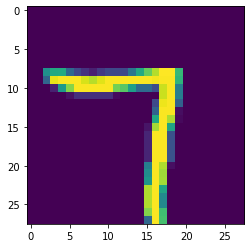

In [26]:
plt.imshow(X_train[9,:,:,0])

# CNN

### Defining Model

In [27]:
model = tf.keras.Sequential(layers=[tf.keras.layers.Conv2D(16,(3,3),input_shape=(28,28,1),padding='same',activation='relu'),
                                    tf.keras.layers.MaxPool2D((2,2)),
                                    tf.keras.layers.Conv2D(32,(3,3),padding='same',activation='relu'),
                                    tf.keras.layers.Conv2D(32,(3,3),padding='same',activation='relu'),
                                    tf.keras.layers.MaxPool2D((2,2)),
                                    tf.keras.layers.Conv2D(64,(3,3),padding='same',activation='relu'),
                                    tf.keras.layers.Conv2D(64,(3,3),padding='same',activation='relu'),
                                    tf.keras.layers.MaxPool2D((2,2)),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(512,activation='relu'),
                                    tf.keras.layers.Dense(256,activation='relu'),
                                    tf.keras.layers.Dense(128,activation='relu'),
                                    tf.keras.layers.Dense(10,activation='softmax')
                                    ])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 64)          3

### Initializing Optimizer

In [0]:
model.compile(optimizer=tf.keras.optimizers.Adam(),loss='categorical_crossentropy',metrics=['accuracy'])

### Data Augmentation

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rotation_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   fill_mode='nearest')

In [0]:
train_datagen.fit(X_train,seed=42)
train_generator = train_datagen.flow(X_train,Y_train,batch_size=64,seed=42)

In [31]:
history = model.fit_generator(train_generator,steps_per_epoch=X_train.shape[0]//64,epochs=100,validation_data=(X_val,Y_val))

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
590/590 [==============================] - 11s 19ms/step - loss: 0.4766 - accuracy: 0.8420 - val_loss: 0.1170 - val_accuracy: 0.9640
Epoch 2/100
590/590 [==============================] - 11s 18ms/step - loss: 0.1321 - accuracy: 0.9596 - val_loss: 0.0693 - val_accuracy: 0.9798
Epoch 3/100
590/590 [==============================] - 10s 18ms/step - loss: 0.0985 - accuracy: 0.9703 - val_loss: 0.0664 - val_accuracy: 0.9821
Epoch 4/100
590/590 [==============================] - 10s 18ms/step - loss: 0.0756 - accuracy: 0.9775 - val_loss: 0.0522 - val_accuracy: 0.9852
Epoch 5/100
590/590 [==============================] - 10s 18ms/step - loss: 0.0700 - accuracy: 0.9787 - val_loss: 0.0452 - val_accuracy: 0.9869
Epoch 6/100
590/590 [==============================] - 10s 17ms/step - loss: 0.0621 - accuracy: 0.9808 - val_loss: 0.0623 - val_accuracy: 0.9836
Epoch 7/100
590/590 [==============================] -

### Evaluating the Model

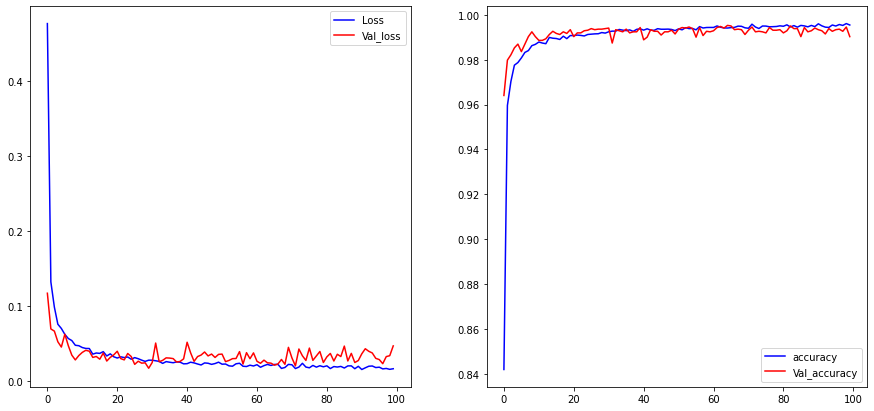

In [34]:
plt.figure(figsize=(15,7))
ax1 = plt.subplot(1,2,1)
ax1.plot(history.history['loss'],c='b',label='Loss')
ax1.plot(history.history['val_loss'],c='r',label='Val_loss')
ax1.legend()
ax2 = plt.subplot(1,2,2)
ax2.plot(history.history['accuracy'],c='b',label='accuracy')
ax2.plot(history.history['val_accuracy'],c='r',label='Val_accuracy')
ax2.legend()

### Try with Adding DropOut layers

Epoch 1/50
590/590 [==============================] - 11s 18ms/step - loss: 0.7753 - accuracy: 0.7331 - val_loss: 0.1353 - val_accuracy: 0.9614
Epoch 2/50
590/590 [==============================] - 10s 17ms/step - loss: 0.2071 - accuracy: 0.9407 - val_loss: 0.0594 - val_accuracy: 0.9826
Epoch 3/50
590/590 [==============================] - 10s 17ms/step - loss: 0.1509 - accuracy: 0.9557 - val_loss: 0.0588 - val_accuracy: 0.9852
Epoch 4/50
590/590 [==============================] - 11s 18ms/step - loss: 0.1257 - accuracy: 0.9643 - val_loss: 0.0435 - val_accuracy: 0.9874
Epoch 5/50
590/590 [==============================] - 10s 18ms/step - loss: 0.1069 - accuracy: 0.9697 - val_loss: 0.0365 - val_accuracy: 0.9898
Epoch 6/50
590/590 [==============================] - 10s 17ms/step - loss: 0.0992 - accuracy: 0.9718 - val_loss: 0.0408 - val_accuracy: 0.9888
Epoch 7/50
590/590 [==============================] - 10s 17ms/step - loss: 0.0893 - accuracy: 0.9744 - val_loss: 0.0436 - val_accuracy:

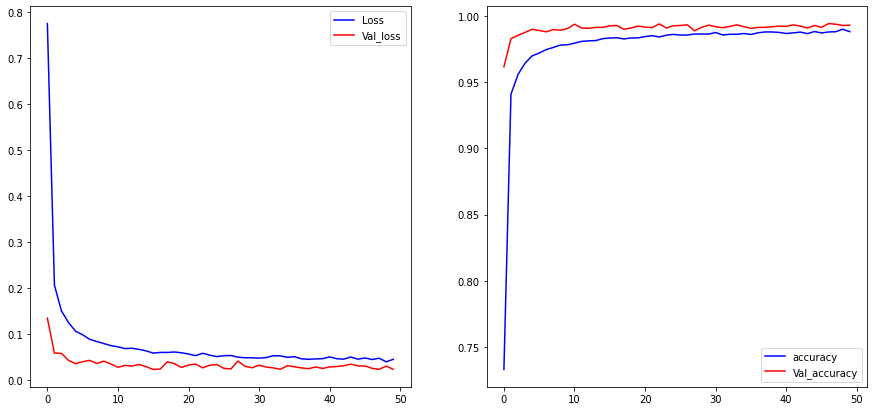

In [35]:
model = tf.keras.Sequential(layers=[tf.keras.layers.Conv2D(16,(3,3),input_shape=(28,28,1),padding='same',activation='relu'),
                                    tf.keras.layers.MaxPool2D((2,2)),
                                    tf.keras.layers.Dropout(0.2),
                                    tf.keras.layers.Conv2D(32,(3,3),padding='same',activation='relu'),
                                    tf.keras.layers.Conv2D(32,(3,3),padding='same',activation='relu'),
                                    tf.keras.layers.MaxPool2D((2,2)),
                                    tf.keras.layers.Dropout(0.2),
                                    tf.keras.layers.Conv2D(64,(3,3),padding='same',activation='relu'),
                                    tf.keras.layers.Conv2D(64,(3,3),padding='same',activation='relu'),
                                    tf.keras.layers.MaxPool2D((2,2)),
                                    tf.keras.layers.Dropout(0.2),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(512,activation='relu'),
                                    tf.keras.layers.Dropout(0.2),
                                    tf.keras.layers.Dense(256,activation='relu'),
                                    tf.keras.layers.Dropout(0.2),
                                    tf.keras.layers.Dense(128,activation='relu'),
                                    tf.keras.layers.Dropout(0.2),
                                    tf.keras.layers.Dense(10,activation='softmax')
                                    ])
model.compile(optimizer=tf.keras.optimizers.Adam(),loss='categorical_crossentropy',metrics=['accuracy'])
history = model.fit_generator(train_generator,steps_per_epoch=X_train.shape[0]//64,epochs=50,validation_data=(X_val,Y_val))
plt.figure(figsize=(15,7))
ax1 = plt.subplot(1,2,1)
ax1.plot(history.history['loss'],c='b',label='Loss')
ax1.plot(history.history['val_loss'],c='r',label='Val_loss')
ax1.legend()
ax2 = plt.subplot(1,2,2)
ax2.plot(history.history['accuracy'],c='b',label='accuracy')
ax2.plot(history.history['val_accuracy'],c='r',label='Val_accuracy')
ax2.legend()

# Confusion Matrix

In [37]:
Y_pred = model.predict(X_val)
Y_pred_class = np.argmax(Y_pred,axis=1)
Y_true = np.argmax(Y_val,axis=1)
Y_pred_class[:10]

array([8, 1, 9, 9, 8, 6, 2, 2, 7, 1])

In [38]:
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


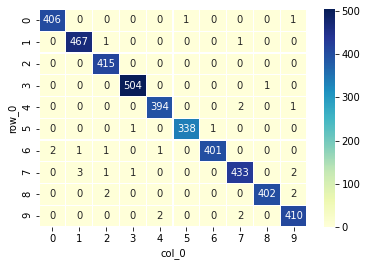

In [44]:
sns.heatmap(pd.crosstab(Y_pred_class,Y_true),linewidths=0.2,cmap="YlGnBu",annot=True,fmt='.0f');

# Predicting Results on Test Data

In [0]:
results = model.predict(test)

In [0]:
results = np.argmax(results,axis=1)

In [47]:
results[:10]

array([2, 0, 9, 0, 3, 7, 0, 3, 0, 3])

In [48]:
sample_sub = pd.read_csv('/tmp/data/sample_submission.csv')
sample_sub.head()

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [50]:
sample_sub.shape

(28000, 2)

In [0]:
sub_file = pd.Series(results,name='Label')

In [0]:
sub_file = pd.concat([pd.Series(range(1,28001),name = 'ImageId'),sub_file],axis=1)

In [52]:
sub_file.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


In [0]:
sub_file.to_csv('/content/DigitRecognizer.csv',index=False)

# Predicting Own Data

In [60]:
from google.colab import files
import os
from tensorflow.keras.preprocessing.image import load_img,img_to_array
file = files.upload()
for fn in file.keys():
  file_path = os.path.join('/content',fn)
  img = load_img(file_path,color_mode='grayscale',target_size=(28,28))
  arr = img_to_array(img)
  arr = np.expand_dims(arr,axis=0)
  pred = model.predict(arr)
  print("Number in Image is : ",np.argmax(pred,axis=1)[0])


Saving 6.png to 6 (2).png
Number in Image is :  6
